### Relevant links

https://www.kaggle.com/c/competitive-data-science-predict-future-sales


Also in this notebook, I am trying to change how features are generated in the v0 version, Here I will not fix the training month to only one month but rather use all data points and take lags. Will take out of time sample as a validation dataset but training will have data from any number of months

### Imports

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline 
%load_ext autotime

In [170]:
from scripts.imports import *
import scripts.kaggle_data as kd
from scripts.utility import *
from scripts.utility_v1 import *

time: 1.28 ms


In [3]:
pd.options.display.max_rows = 4000
pd.set_option('display.max_columns', 999)
pd.options.mode.chained_assignment = None

time: 1.86 ms


### Getting data

In [ ]:
current_path = os.getcwd()
data_dir_path = os.path.join(current_path,"data")

if not os.path.exists(data_dir_path):
    os.mkdir(data_dir_path)

print(data_dir_path) #Never print

In [ ]:
kd.download_data('competitive-data-science-predict-future-sales',current_path)

In [4]:
#Listify files to download
all_data_files = os.listdir('data/') #Getting all files in data folder in a list
all_data_files = [x for x in all_data_files if x.endswith('.csv')] #Removing .ipynb files
all_data_files = [remove_from_right(x,4) for x in all_data_files] #Removing .csvs
all_data_files

['shops',
 'submission__xgb_v0',
 'items',
 'submission_v1',
 'item_categories',
 'sales_train',
 'submission__xgb_v2',
 'sample_submission',
 'test',
 'submission__xgb_v1']

time: 129 ms


In [5]:
for i in all_data_files:
    print(i + "=" + f"kd.read_data('data/','csv','{i}')")
    print("")
    exec(i + "=" + f"kd.read_data('data/','csv','{i}')")
    exec(f"shape = {i}.shape")
    print(f"Shape of {i}: ", shape)
    exec(f"data_types = {i}.dtypes")
    print("")
    print(f"Data types in {i}: \n \n ", data_types)
    print("---------------------")

shops=kd.read_data('data/','csv','shops')

Shape of shops:  (60, 2)

Data types in shops: 
 
  shop_name    object
shop_id       int64
dtype: object
---------------------
submission__xgb_v0=kd.read_data('data/','csv','submission__xgb_v0')

Shape of submission__xgb_v0:  (214200, 2)

Data types in submission__xgb_v0: 
 
  ID                  int64
item_cnt_month    float64
dtype: object
---------------------
items=kd.read_data('data/','csv','items')

Shape of items:  (22170, 3)

Data types in items: 
 
  item_name           object
item_id              int64
item_category_id     int64
dtype: object
---------------------
submission_v1=kd.read_data('data/','csv','submission_v1')

Shape of submission_v1:  (214200, 2)

Data types in submission_v1: 
 
  ID                  int64
item_cnt_month    float64
dtype: object
---------------------
item_categories=kd.read_data('data/','csv','item_categories')

Shape of item_categories:  (84, 2)

Data types in item_categories: 
 
  item_category_name   

In [6]:
save_test = test

time: 957 µs


### Testing data

#### Structural checks

In [ ]:
#Unique data values
#sales_train >> \
#select(X.date,X.date_block_num) >> \
#distinct(X.date,X.date_block_num) >> \
#arrange(X.date_block_num, ascending = True) 

#Finding
#We have daily sales data as well

In [ ]:
#Check for missing value in train data
#for k in sales_train.columns:
    #display_all(sales_train >> summarise_each([null_percent],k))

#### See headers of all data

In [ ]:
sales_train >> head

In [ ]:
shops >> head

In [ ]:
items >> head

In [ ]:
item_categories >> head

In [ ]:
test >> head

### Feature engineering

#### Create features

In [7]:
# Add dates to training data
sales_train = add_datepart(df = sales_train, custom_date_format = '%d.%m.%Y',field_name = 'date', drop = False)
#Assignment is done to avoid printing the dataframe
raw_data = sales_train

time: 4.14 s


In [8]:
#Convert item_id and shop_id as strings
#Replace negative values of sales with 0 and add separate field for capturing returns
raw_data = raw_data >> mutate(item_id = X.item_id.astype(str), shop_id = X.shop_id.astype(str)) >> \
mutate(item_cnt_day = if_else(X.item_cnt_day < 0, 0, X.item_cnt_day),
      item_cnt_day_return = if_else(X.item_cnt_day < 0, -X.item_cnt_day,0))

time: 10.9 s


In [95]:
#raw_data >> select(X.date_block_num,X.Month,X.Year) >> \
#distinct(X.date_block_num,X.Month,X.Year) >> arrange(X.date_block_num)
#Will use date block num as a unique month idetifier from now on

time: 1.28 ms


In [147]:
#Compute monthly metrics
#Price changes 
#number of purchases
#Translate everything daily to monthly
#Standard deviation is a time consuming computation in dask, so not inclusinf for now

metric_dictionary = {'item_cnt_day': ['sum','count'],'item_price' : ['mean']}

raw_data_month = dd_summarise_m(raw_data,['item_id','shop_id','date_block_num'],metric_dictionary)
raw_data_month = raw_data_month >> mutate(per_day_sales = X.item_cnt_day_sum/X.item_cnt_day_count)

time: 4.78 s


In [148]:
#Cap sales value from 0 to 20
raw_data_month = raw_data_month >> mutate(item_cnt_day_sum = if_else(X.item_cnt_day_sum > 20, 20, X.item_cnt_day_sum))

time: 796 ms


In [242]:
#Unique values in each field
all_items = raw_data >> select(X.item_id) >> distinct(X.item_id)
print("All items: ", all_items.shape)
all_shops = raw_data >> select(X.shop_id) >> distinct(X.shop_id)
print("All shops: ", all_shops.shape)
all_months = raw_data >> select(X.date_block_num) >> distinct(X.date_block_num)
print("All months: ", all_months.shape)
item_shop = raw_data >> select(X.item_id,X.shop_id) >> distinct(X.item_id,X.shop_id)
print("All item-shop combination: ", item_shop.shape)
item_shop_from_test = save_test >> \
mutate(item_id = X.item_id.astype(str), shop_id = X.shop_id.astype(str)) >> \
select(X.item_id,X.shop_id) >> distinct(X.item_id,X.shop_id)
print("All item-shop combination from test: ", item_shop_from_test.shape)
item_shop_all = item_shop >> bind_rows(item_shop_from_test) >> \
select(X.item_id,X.shop_id) >> distinct(X.item_id,X.shop_id)
print("All item-shop combination from train + test: ", item_shop_all.shape)

All items:  (21807, 1)
All shops:  (60, 1)
All months:  (34, 1)
All item-shop combination:  (424124, 2)
All item-shop combination from test:  (214200, 2)
All item-shop combination from train + test:  (526920, 2)
time: 4.89 s


In [243]:
#Train and valid
item_shop_all_merge = item_shop_all >> mutate(key = 1)
all_months = all_months >> mask(X.date_block_num > 8) >> mutate(key = 1) #Keeping 2 Novembers
sparse_raw_data_month = item_shop_all_merge >> inner_join(all_months, by = ['key']) >> drop(X.key) >> \
left_join(raw_data_month, by = ['item_id','shop_id','date_block_num'])

sparse_raw_data_month.item_cnt_day_sum.fillna(0,inplace = True) 
sparse_raw_data_month.item_cnt_day_count.fillna(0,inplace = True)
sparse_raw_data_month.fillna(-999,inplace = True) #For price and sales per day


print("Shape of sparse data: ", sparse_raw_data_month.shape )

#Test
test = save_test >> mutate(item_id = X.item_id.astype(str), 
                           shop_id = X.shop_id.astype(str), 
                           date_block_num = 34) >> drop(X.ID)

print("Shape of test data: ", test.shape )

Shape of sparse data:  (13173000, 7)
Shape of test data:  (214200, 3)
time: 16.1 s


In [244]:
#Select training and valid months
#Training: Past November: 22   and October: 21 , take other months as well
#Since capturing all months will isolate nature of trips in November
#Valid: Current October: 33

#Start creating lag variables for everything and then merge with test data to attach the features

samples = item_shop_all >> sample(100000) 
sparse_raw_data_month_sample = sparse_raw_data_month >> inner_join(samples, by = ['item_id','shop_id']) 

metric_list = ['item_cnt_day_sum','item_price_mean']#,'item_cnt_day_count','per_day_sales'
sparse_raw_data_month_sample = apply_lag_v2(sparse_raw_data_month_sample,metric_list,16)


print('Shape before NaN removal: ',sparse_raw_data_month_sample.shape )
sparse_raw_data_month_sample.dropna(inplace = True)
print('Shape after NaN removal: ',sparse_raw_data_month_sample.shape )

#Get the same metrics for test data
sparse_raw_data_month_test = test >> select(X.item_id,X.shop_id) >> \
inner_join(sparse_raw_data_month, by = ['item_id','shop_id']) 

concatenated_test = test >> bind_rows(sparse_raw_data_month_test) >> arrange(X.item_id,X.shop_id,X.date_block_num)

test = apply_lag_v2(concatenated_test,metric_list,16)
test = test >> mask(X.date_block_num == 34) 

test.item_cnt_day_sum.fillna(0,inplace = True) 
test.item_cnt_day_count.fillna(0,inplace = True) 
test.item_price_mean.fillna(-999,inplace = True) 
test.per_day_sales.fillna(-999,inplace = True) 


print('Shape before NaN removal: ',test.shape )
test.dropna(inplace = True)
print('Shape after NaN removal: ',test.shape ) #There shouldn't be any drop

lag: 1 done
lag: 2 done
lag: 3 done
lag: 4 done
lag: 5 done
lag: 6 done
lag: 7 done
lag: 8 done
lag: 9 done
lag: 10 done
lag: 11 done
lag: 12 done
lag: 13 done
lag: 14 done
lag: 15 done
lag: 16 done
Metric: item_cnt_day_sum done
lag: 1 done
lag: 2 done
lag: 3 done
lag: 4 done
lag: 5 done
lag: 6 done
lag: 7 done
lag: 8 done
lag: 9 done
lag: 10 done
lag: 11 done
lag: 12 done
lag: 13 done
lag: 14 done
lag: 15 done
lag: 16 done
Metric: item_price_mean done
Shape before NaN removal:  (2500000, 39)
Shape after NaN removal:  (900000, 39)
lag: 1 done
lag: 2 done
lag: 3 done
lag: 4 done
lag: 5 done
lag: 6 done
lag: 7 done
lag: 8 done
lag: 9 done
lag: 10 done
lag: 11 done
lag: 12 done
lag: 13 done
lag: 14 done
lag: 15 done
lag: 16 done
Metric: item_cnt_day_sum done
lag: 1 done
lag: 2 done
lag: 3 done
lag: 4 done
lag: 5 done
lag: 6 done
lag: 7 done
lag: 8 done
lag: 9 done
lag: 10 done
lag: 11 done
lag: 12 done
lag: 13 done
lag: 14 done
lag: 15 done
lag: 16 done
Metric: item_price_mean done
Shape 

In [245]:
#Get date features for all date block num
date_block_num_mapping = dd_summarise_m(raw_data,['date_block_num'],{'Month':['min']})
sparse_raw_data_month_sample = sparse_raw_data_month_sample >> left_join(date_block_num_mapping, by = ['date_block_num'])
test = test >> mutate(Month_min = 11)

time: 1.64 s


In [246]:
#Create new features from the lag features

time: 907 µs


In [247]:
#Add item presence (Think how to add lag varables for this)

time: 1.21 ms


In [248]:
#Item category size 
sparse_raw_data_month_sample = item_category_size(sparse_raw_data_month_sample,items)
test = item_category_size(test,items)

time: 2.85 s


In [249]:
#Now generate train, valid and test DFs

#test = test
train = sparse_raw_data_month_sample >> mask(X.date_block_num != 33)
valid = sparse_raw_data_month_sample >> mask(X.date_block_num == 33)

time: 739 ms


### EDA

#### Check distribution

In [ ]:
check = dd_summarise(raw_data,['date_block_num','item_id','shop_id'],'item_cnt_day','sum')

In [ ]:
check[check.item_cnt_day > 20].shape[0]/check.shape[0]

In [ ]:
sns.distplot(check.item_cnt_day[check.item_cnt_day>0])

### Modelling

#### Xgboost

In [250]:
##data preparation
ind_columns = train.columns.to_list()

list_to_remove = ['shop_id','item_id','item_cnt_day_sum','date_block_num','item_price_mean','per_day_sales','item_cnt_day_count']
ind_columns = remove_elements(ind_columns, list_to_remove )

dep_coloumns = ["item_cnt_day_sum"]

cont_vars = train.head(5).select_dtypes(include= [np.number]).columns.to_list()
cont_vars = remove_elements(cont_vars, ['item_cnt_day_sum','date_block_num','item_price_mean','per_day_sales','item_cnt_day_count'])

cat_vars = train.head(5).select_dtypes(include= [object]).columns.to_list()
list_to_remove = ['shop_id','item_id']

cat_vars = remove_elements(cat_vars, list_to_remove)


x_train = train[ind_columns]
y_train = train[dep_coloumns]

x_test = test[ind_columns]

x_valid = valid[ind_columns]
y_valid = valid[dep_coloumns]

print("Shape of training data: ", x_train.shape)
print("Shape of validation data: ", x_valid.shape)
print("Shape of test data: ", x_test.shape)

xg_train = xgb.DMatrix(x_train, label = y_train)
xg_test = xgb.DMatrix(x_test)
xg_valid = xgb.DMatrix(x_valid, label = y_valid)

Shape of training data:  (800000, 35)
Shape of validation data:  (100000, 35)
Shape of test data:  (214200, 35)
time: 1.23 s


In [251]:
#Model
param = {'max_depth':12,
         'eta':0.05, # learning rate
         'gamma':2,
         'min_child_weight':10,
         'objective':'reg:squarederror',
         'eval_metric': 'rmse' ,
         'colsample_bytree': 0.6}

watchlist  = [(xg_valid, 'valid')]
num_round = 1000

xgm = xgb.train(param, xg_train, num_round, evals = watchlist, early_stopping_rounds=10)

[0]	valid-rmse:0.845134
Will train until valid-rmse hasn't improved in 10 rounds.
[1]	valid-rmse:0.827121
[2]	valid-rmse:0.810586
[3]	valid-rmse:0.795131
[4]	valid-rmse:0.782807
[5]	valid-rmse:0.769841
[6]	valid-rmse:0.760314
[7]	valid-rmse:0.749686
[8]	valid-rmse:0.742185
[9]	valid-rmse:0.734876
[10]	valid-rmse:0.72629
[11]	valid-rmse:0.719801
[12]	valid-rmse:0.712367
[13]	valid-rmse:0.705472
[14]	valid-rmse:0.699442
[15]	valid-rmse:0.694173
[16]	valid-rmse:0.689444
[17]	valid-rmse:0.684758
[18]	valid-rmse:0.681156
[19]	valid-rmse:0.678469
[20]	valid-rmse:0.675161
[21]	valid-rmse:0.67191
[22]	valid-rmse:0.669826
[23]	valid-rmse:0.667602
[24]	valid-rmse:0.665438
[25]	valid-rmse:0.664046
[26]	valid-rmse:0.662449
[27]	valid-rmse:0.661219
[28]	valid-rmse:0.659719
[29]	valid-rmse:0.658614
[30]	valid-rmse:0.657602
[31]	valid-rmse:0.656648
[32]	valid-rmse:0.655956
[33]	valid-rmse:0.655186
[34]	valid-rmse:0.654531
[35]	valid-rmse:0.654027
[36]	valid-rmse:0.653558
[37]	valid-rmse:0.653165
[38]

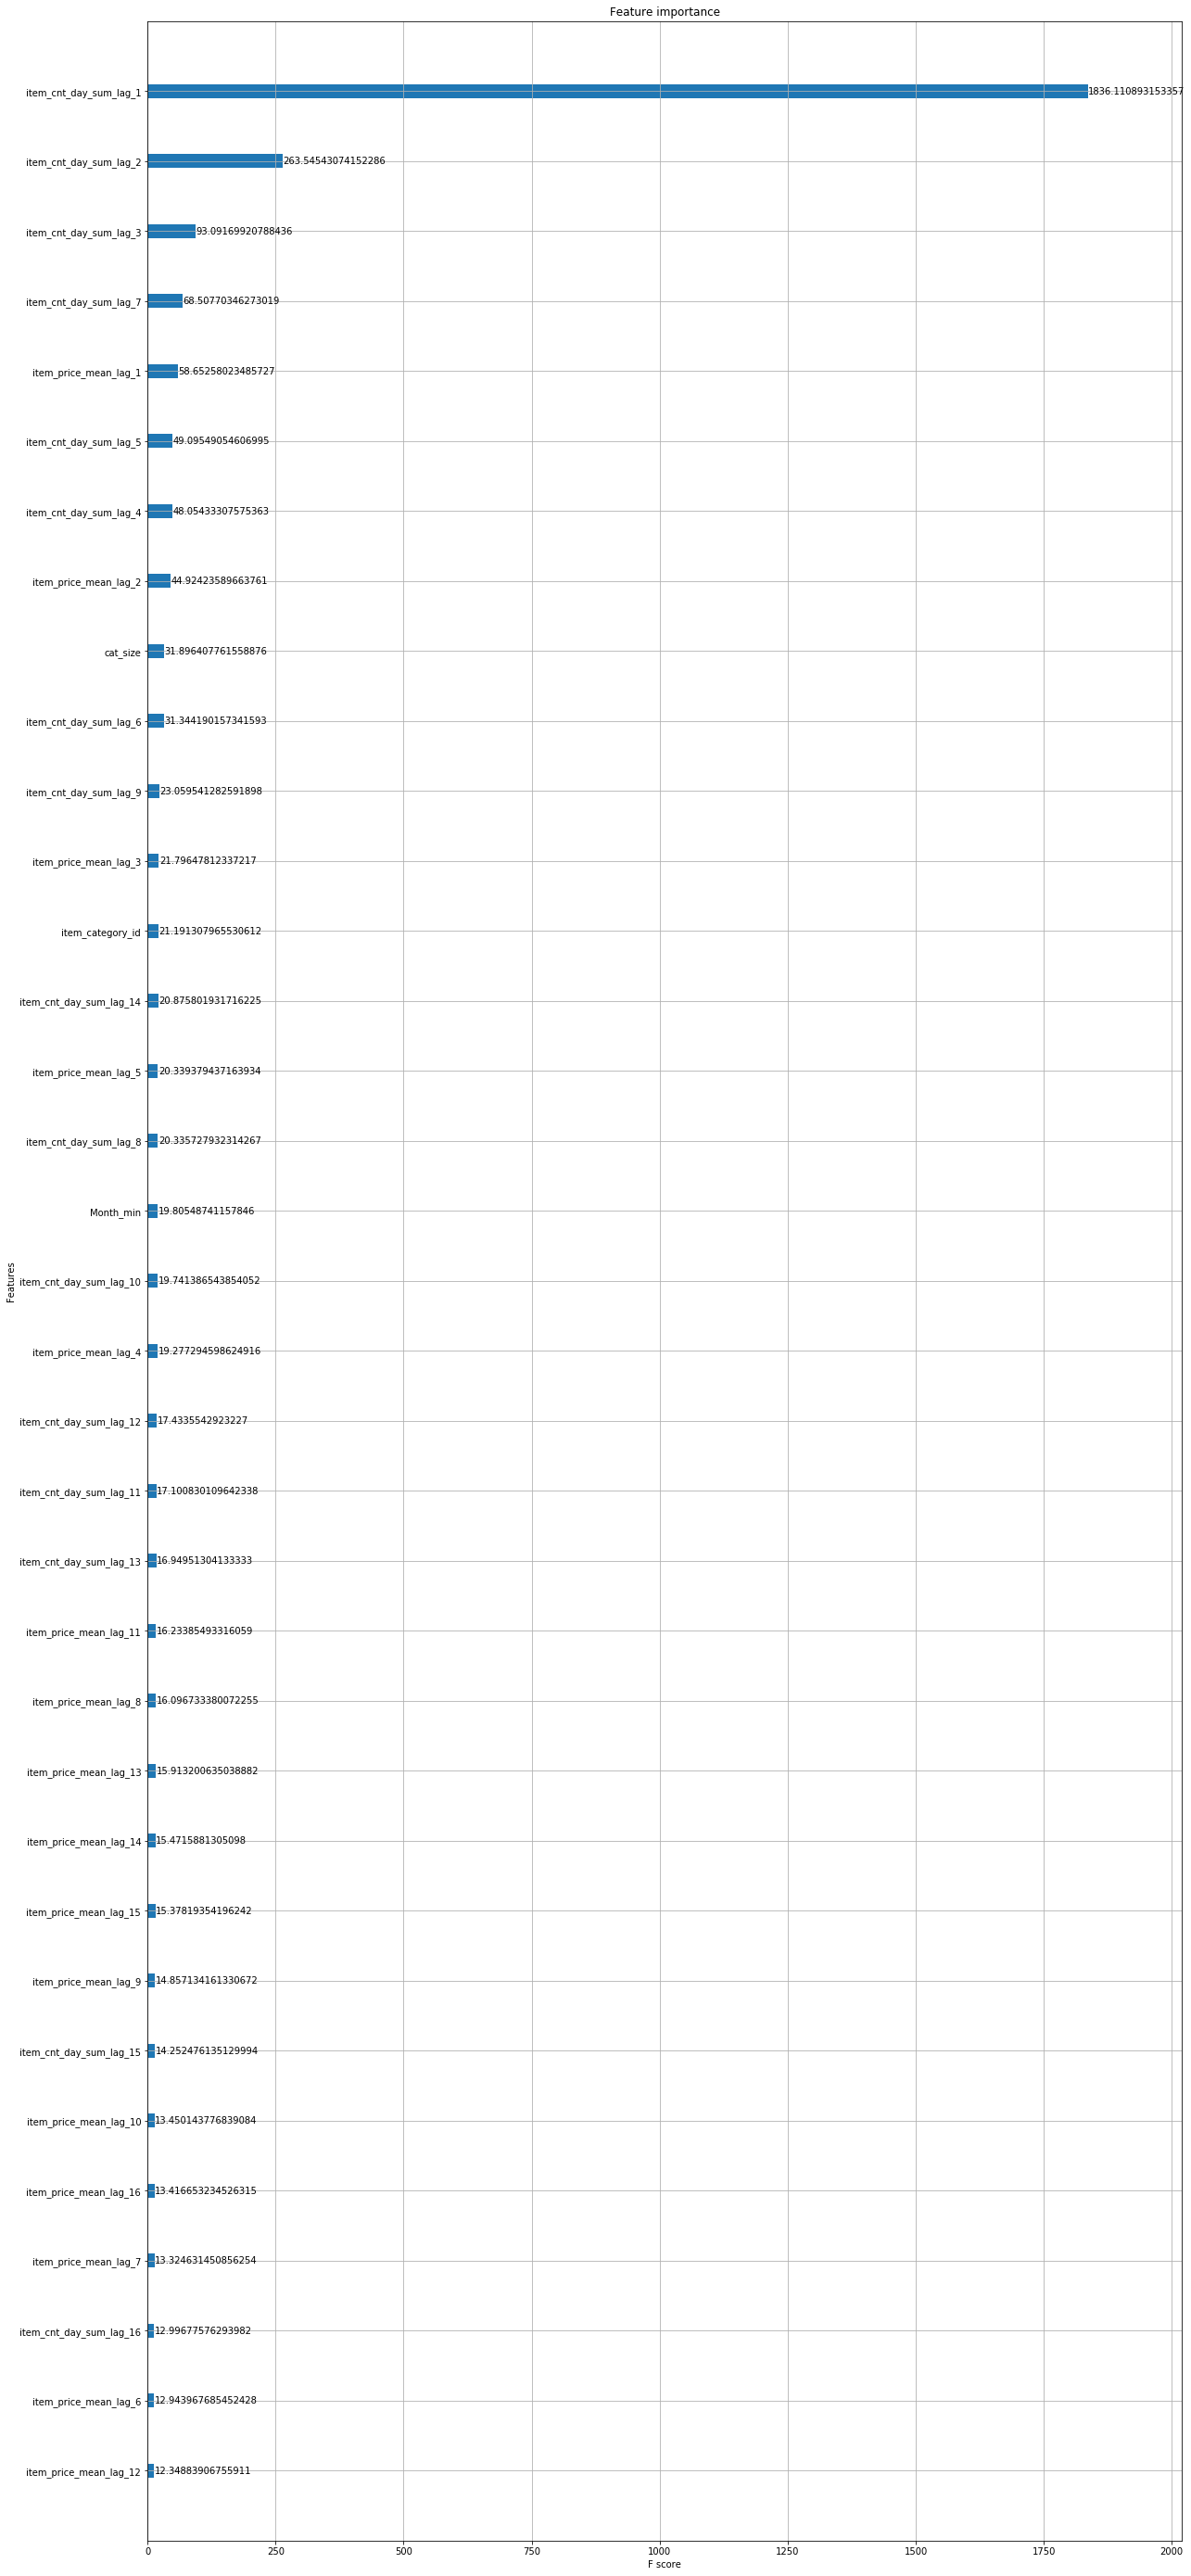

time: 5.45 s


In [252]:
my_plot_importance(xgm,(20,50),importance_type='gain')

In [253]:
#RMSE in validation data
rmse(xgm.predict(xg_valid),y_valid.values.ravel())

0.6507867093607934

time: 13.5 ms


In [254]:
#RMSE in train data
rmse(xgm.predict(xg_train),y_train.values.ravel())

0.5321633292762353

time: 16.5 ms


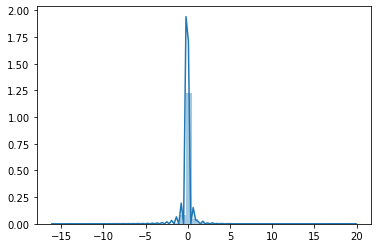

time: 452 ms


In [255]:
valid_predictions = xgm.predict(xg_valid)
valid_predictions = valid >> mutate(item_cnt_day_predicted = valid_predictions) >> \
mutate(errors = (X.item_cnt_day_sum - X.item_cnt_day_predicted))

vp = valid_predictions

sns.distplot(vp.item_cnt_day_sum - vp.item_cnt_day_predicted)

### Submission

#### XGBoost

In [256]:
test_predictions = xgm.predict(xg_test)
test_predictions.shape

(214200,)

time: 322 ms


In [257]:
test_submission = save_test >> mutate(item_cnt_month = test_predictions) >> drop(X.item_id,X.shop_id)

time: 10.3 ms


In [258]:
test_submission.to_csv('data/submission__xgb_v5.csv', index=False)

time: 1.87 s


### Unit tests